# Convolutional Neural Network model - an introduction (Part 2)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/paolodeangelis/Sistemi_a_combustione/blob/main/3.2-CNN_Intro_P2.ipynb)

## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to `Edit` > `Notebook Settings`
- Select `T4 GPU` from the Hardware Accelerator drop-down
- If the GPU nodes are busy, use the CPU one.

Next, we'll check that we can connect to the GPU:

In [92]:
import warnings

import tensorflow as tf

print("Tensorflow version " + tf.__version__)

device_name = tf.test.gpu_device_name()  # GPU detection
if device_name == "/device:GPU:0":
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f"Running on GPU at: {device_name}")
else:
    warnings.warn("GPU device not found")
    try:
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(
            tpu=""
        )  # TPU detection
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.TPUStrategy(resolver)
        print(
            "Running on TPU at:",
            "\n\t".join([f"{i}" for i in tf.config.list_logical_devices("TPU")]),
        )
    except ValueError:
        warnings.warn("TPU device not found")
        warnings.warn("Default parallization strategy will be used")
        strategy = tf.distribute.get_strategy()

Tensorflow version 2.14.0
Running on GPU at: /device:GPU:0


## Installing Libraries

We begin by installing the necessary libraries to support our data manipulation, visualization, and deep learning modeling. (Note: `Tensorflow` and `Keras` are already installed on Colab)

In [ ]:
%pip install numpy pandas scipy matplotlib  scikit-learn

And now we import the necessary libraries

In [11]:
import os  # Operating system-related functions
import pathlib  # Path manipulation and filesystem-related operations

import matplotlib.pyplot as plt  # Data visualization library
import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation and analysis library
import tensorflow as tf  # Deep learning framework for neural networks
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from IPython.display import display, clear_output, HTML
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import Sequential, layers, losses, optimizers, preprocessing
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

## Introduction to Convolutional Neural Networks (CNNs)

Convolutional Neural Networks (CNNs) are a specialized type of Deep Learning networks predominantly used in the field of image analysis and computer vision. Unlike traditional neural networks, where each neuron is connected to all neurons in the previous layer, CNNs leverage a more structured approach suited for handling high-dimensional input such as images.

<img style="display: block; margin: auto;" alt="NN sketch" src="https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/assets/img/cnn.png">

### Key Components of a CNN
- **Convolutional Layer**: This is the core building block of a CNN. The layer's neurons apply a convolution operation to the input, passing the result to the next layer. This operation involves a filter or kernel - a small matrix of weights - that slides over the input image to produce a feature map, highlighting features like edges, textures, etc.

- **Kernel/Filter**: In the convolutional layer, a kernel (or filter) is a small matrix used to detect specific types of features in the input. Each filter in a convolutional layer represents a particular aspect of the input (like an edge in a certain orientation).

- **Pooling Layer**: Following convolutional layers, pooling layers are used to reduce the spatial dimensions (width and height) of the input volume for the next convolutional layer. Common pooling methods include max pooling and average pooling, which help to make the representation smaller and more manageable.

- **Fully Connected Layer**: After several convolutional and pooling layers, the high-level reasoning in the neural network is done via fully connected layers. Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks. Their role is to take these high-level filtered features and use them for classifying the input image into various categories based on the training dataset.

- **Activation Functions**: Like other neural networks, CNNs also use activation functions to introduce non-linear properties to the network. The Rectified Linear Unit (ReLU) is the most commonly used activation function in deep learning models.

- **Strides and Padding**: These are additional parameters associated with the convolutional layer. Stride controls how the filter convolves around the input volume, and padding deals with the size of the output volume.


### Introduction to Convolution in Mathematics

Convolution is a fundamental mathematical operation that is central to many applications in engineering and science, particularly in signal processing, image manipulation, dynamic analysis etc.
At its core, convolution is an operation that combines two functions to produce a third function that expresses how the shape of one is modified by the other. In a more intuitive sense, it can be thought of as a way of 'mixing' two signals together or applying a filter to a signal.

Mathematically, the convolution of two functions $f$ and $g$ is defined as:

$$ (f * g)(t) = \int_{-\infty}^{\infty} f(\tau)g(t - \tau) d\tau $$

For discrete functions, such as pixel values in an image, the convolution is defined as:

$$ (f * g)[n] = \sum_{m=-M}^{M} f[m]g[n - m] $$

where $M$ is the range of summation.

Let's see a simple example in Python using one-dimensional arrays.


In [65]:
# @title 1D-convolution animation

# Define a simple 1D signal and a kernel for convolution
f = np.zeros(100)
f[25:50] = np.power(np.arange(25), 3) * 0.005
f[49:74] = np.power(np.arange(25), 3)[::-1]   * 0.005
g  = np.zeros(100)
g[0:20] = np.arange(20)*1.5
fg = np.zeros(f.shape)

# Prepare the figure
with plt.style.context("seaborn-v0_8-paper"):
    fig = plt.figure(figsize=(12,4))
    grid = fig.add_gridspec(1, 2)
    ax0 = fig.add_subplot(grid[0])
    ax1 = fig.add_subplot(grid[1])
    line0, = ax0.plot(f, label='$f$')
    line1, = ax0.plot(g, label='$g$')
    line2, = ax1.plot(fg, label='$f * g$', color="#6aa94f")
    ax0.legend(loc='upper right')
    ax1.legend(loc='upper right')
    ax1.set_ylim([-1.3e4*0.05, 1.3e4])

plt.close()

# Animation update function
def update(i):
    line1.set_ydata(np.roll(g, i))
    if i < len(fg):
        fg[i] = np.sum(f * np.roll(g, i))
    line2.set_ydata(fg)
    return line1, line2,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(f)+1, interval=50, blit=True)

clear_output()


In [66]:
HTML(ani.to_jshtml())

### Convolution layer

<img style="display: block; margin: auto;" alt="NN sketch" src="https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/assets/img/covolution_stride_padding.gif">


The convolutional layer is the Neural Networks (NN) solution to replace the fully connected Perceptron layer.
When dealing with n-dimensional tensor (with n > 1), the memory required to build a classic NN raises fast and reaches a value that makes
the use of this technique unuseful. The solution is, instead to connect each neuron to every input pixel, we use a **filter** (a.k.a. **kernel**)
which scans the previous layer's input, and the resulting product (convolution) builds the output.
The main and crucial hyperparameter of this layer is the **stride** and **padding**:

- **Stride** is the number of pixels shifts over the input matrix.
When the stride is 1 then we move filters to 1 pixel at a time.
When the stride is 2, then we move the filters to 2 pixels at a time and so on.

- **Padding** is the amount of zeoro-element added to an image (input tensor) when it is being processed by the kernel of a CNN.

Changin the *stride* and *padding* chenge the output layer shape, and the output width or height can be compute with the equation:

$$ O = \dfrac{I - K + 2P}{S} +1 $$

where $O$ is the output width/height, $I$ is the input width/height, $K$ is the kernel size, $P$ is teh padding and $S$ is the stide.

Note with a kernel of 3x3 ($K=3$) we have that settintg the `stride=None` and `padding=2` the input and output layer have the same size (this is usualy called "same" padding).

We can olso visualize the 2D convolution with the following python code:

In [67]:
# @title 2D-convolution animation

# Create a simple 2D array (image)
image = np.random.rand(8, 8)

# Define a 3x3 convolution kernel
kernel = np.array([[.33, 0, 0],
                   [0, .33, 0],
                   [0, 0, .33]])
conv_img = np.zeros((image.shape[0]-2, image.shape[0]-2))

# Set up the figure for animation
fig = plt.figure(figsize=(15,5))
grid = fig.add_gridspec(10, 7)
ax0 = fig.add_subplot(grid[:,:3])
ax1 = fig.add_subplot(grid[4:6,3])
ax2 = fig.add_subplot(grid[:,4:])
im = ax0.imshow(image, cmap='Blues', interpolation='none', aspect='equal', vmin=0, vmax=1)
km = ax1.imshow(kernel, cmap='Reds', interpolation='none', aspect='equal')
cm = ax2.imshow(conv_img, cmap='Greens', interpolation='none', aspect='equal', vmin=0, vmax=1)
ax0.set_title("Input matrix")
ax0.axis('off')
ax1.set_title("3x3 Kernel")
ax1.axis('off')
ax2.set_title("Convolute Result")
ax2.axis('off')

plt.colorbar(im, location='bottom')
plt.colorbar(km, location='bottom')
plt.colorbar(cm, location='bottom')


# Add a rectangle to highlight the kernel area
rect_i = Rectangle((0.5, 0.5), kernel.shape[1], kernel.shape[0], fill=False, color='red', lw=2)
ax0.add_patch(rect_i)
rect_o = Rectangle((-0.5, -0.5), 1, 1, fill=False, color='red', lw=2)
ax2.add_patch(rect_o)

# don't show the plain background
plt.close()


# Animation function to update the figure
def animate(k, image, kernel, conv_img):
    end_size = np.array(image.shape) - np.array(kernel.shape) + 1
    i = k // end_size[0]
    j = k % end_size[1]
    if i + kernel.shape[0] > image.shape[0]:
        return im, cm

    temp = image[i:i+kernel.shape[0], j:j+kernel.shape[1]]
    conv_value = np.sum(temp * kernel)

    # Update the image with convolution result at the current position
    conv_img[i, j] = conv_value

    # Update rectangle position
    rect_i.set_xy((j-.5, i-.5))
    rect_o.set_xy((j-.5, i-.5))

    im.set_array(image)
    cm.set_array(conv_img)
    return im, cm

# Create animation
end_size = np.array(image.shape) - np.array(kernel.shape) + 1
ani = animation.FuncAnimation(fig, animate, fargs=(image, kernel, conv_img), frames=range(np.prod(end_size)), interval=300)

clear_output()

In [68]:
HTML(ani.to_jshtml())

### Pooling layer

A pooling layer is nothing but reducing the information size.
While in convolution out NN is "learning" in this layer, we are reducing the data size.
Therefore we are losing info, but we are highlighting the only feature that matters.

<img style="display: block; margin: auto;" alt="NN sketch" src="https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/assets/img/pooling.png">

### Download dataset files

Then we load the database. Because it is a standard database (a sort of *Hello World* for CNN), it is already included in TF, so we only need to run the following function:

In [69]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


### Dataset ispection and pre-processing

Let’s look how many images we have:

In [70]:
print(f"Train Images:{train_images.shape}")
print(f"Train Labels:{len(train_labels)}")
print(f"Test Images:{test_images.shape}")
print(f"Test Labels:{len(test_labels)}")

Train Images:(60000, 28, 28)
Train Labels:60000
Test Images:(10000, 28, 28)
Test Labels:10000


Thus we have 60k images for the training and 10k for the test (86%-14% split).

Now let see what there is inside this database by randomly plotting 36 pictures:

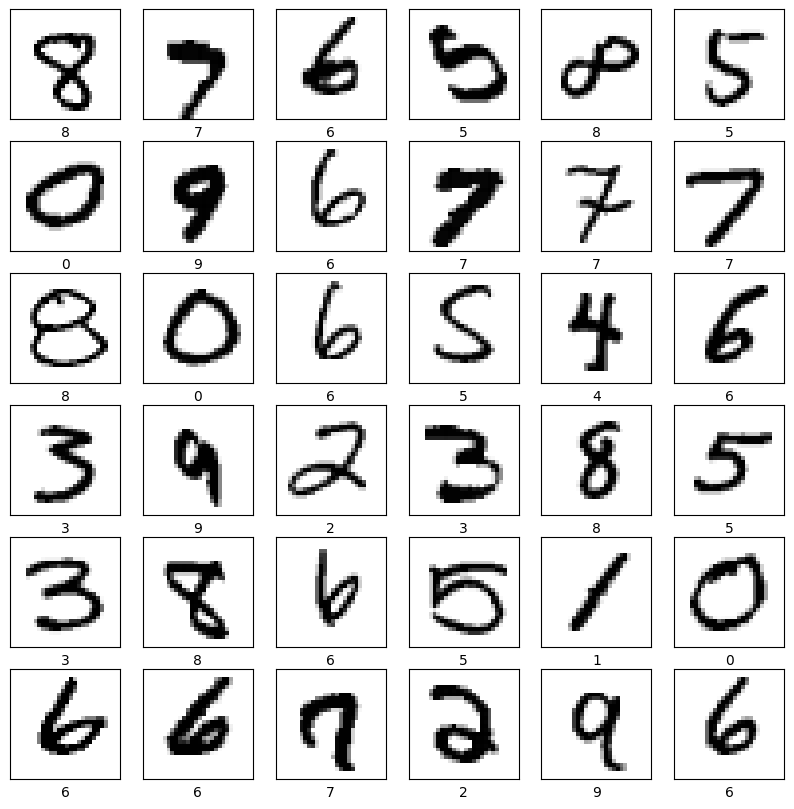

In [71]:
# set a proper figure dimension
plt.figure(figsize=(10,10))
# pick 36 random digits in range 0-59999
# inner bound is inclusive, outer bound exclusive
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    # show images using a binary color map (i.e. Black and White only)
    plt.imshow(train_images[image_ind], cmap=plt.cm.binary)
    # set the image label
    plt.xlabel(train_labels[image_ind])

### Pre-Processing

As discussed in the previous lesson, neural networks perform better when using floating-point numbers that are within the interval $[0,1]$. Since our data is in RGB format and assumes integer values between 0 and 255, we perform the following normalization:

In [72]:
# from range 0-255 to 0-1
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)

## Model 1: Handwritten digit recognition

Now it's time to build the model!
We are going to use a keras sequential model (as usual) with three different layers. This model represents a feed-forward Fully Connected Neural Network (one that passes values from left to right).

In [96]:
def build_model_1(shape_img: tuple, num_class: int) -> tf.keras.models.Sequential:
    """
    Build a the first possible architecture for our neural network model.
    Args:
        shape_img (tuple): The shape of the input images (height, width, channels).
        num_class (int): The number of classes for the classification task.

    Returns:
        tf.keras.models.Sequential: A Keras Sequential model.
    """
    model = tf.keras.models.Sequential(
        [
            layers.Input(shape=shape_img, name="input_layer"),
            # Block 1, 3x3 kerne and extract 12 feature maps & 2x2 max pooling
            layers.Conv2D( 12, (3, 3), activation='relu', padding='same', name='block1_conv1'),
            layers.MaxPooling2D((2, 2), name='block1_pool'),
            # Block 2,  3x3 kerne and extract 24 feature maps & 2x2 max pooling
            layers.Conv2D(24, (3, 3), activation='relu', padding='same', name='block2_conv1'),
            layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'),
            # Block 3,  3x3 kerne and extract 36 feature maps & 2x2 max pooling
            layers.Conv2D(36, (3, 3), activation='relu', padding='same', name='block3_conv1'),
            layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'),
            # Classification block (FCNN)
            layers.Flatten(name='flatten'),
            layers.Dense(128, activation='relu', name='fully_conected_1'),
            layers.Dropout(rate=0.5),
            layers.Dense(num_class, activation="softmax", name='output_layer'),
        ]
    )
    return model


Let's call the function to build our model.

In [97]:
model_1 = build_model_1(
    train_images.shape[1:],  # image shape
    10 # number of digits (i.e 0, 1, 2, 3, 4, 5, 6 ,7 , 8, 9)
    )

#### Model Summary and Structure Visualization

Let's examine the summary of our compiled model and visualize its architecture.


In [98]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 28, 28, 12)        120       
                                                                 
 block1_pool (MaxPooling2D)  (None, 14, 14, 12)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 14, 14, 24)        2616      
                                                                 
 block2_pool (MaxPooling2D)  (None, 7, 7, 24)          0         
                                                                 
 block3_conv1 (Conv2D)       (None, 7, 7, 36)          7812      
                                                                 
 block3_pool (MaxPooling2D)  (None, 3, 3, 36)          0         
                                                                 
 flatten (Flatten)           (None, 324)              

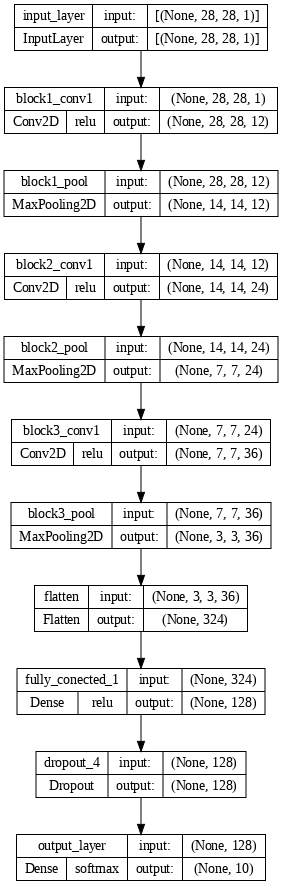

In [99]:
tf.keras.utils.plot_model(
    model=model_1, rankdir="TB", dpi=72, show_shapes=True, show_layer_activations=True
)

#### Model Compilation

Now we will compile our neural network model. Model compilation involves defining key components, such as the loss function, optimizer, learning rate, and metrics.

##### Loss Function

For our classification task, similar to the first binary model shown in Lab 2, we use the Categorical Crossentropy loss function. This loss function is suitable for multi-class classification problems where the classes are mutually exclusive, meaning each entry belongs to precisely one class.

The Categorical Crossentropy loss function calculates the loss by comparing the model's predicted probability distribution $ P $ for each class with the actual distribution $ Y $. The formula for this loss function is:

$ \text{Categorical Crossentropy} = -\sum_{i=1}^{C} y_i \log(p_i) $

where $ C $ is the number of classes, $ y_i $ is a binary indicator (0 or 1) of whether class $ i $ is the correct classification, and $ p_i $ is the predicted probability of the class $ i $.

The loss is the sum of the negative log probabilities of the correct class across all samples in the dataset. This function penalizes incorrect predictions more heavily, thereby guiding the model towards more accurate predictions.

> ℹ️ Note:
> We are going to use the *Sparse* version of the *Categorical Crossentropy* to avoid the encoding step.

In [100]:
loss = losses.SparseCategoricalCrossentropy()

##### Optimizer

We use the *Adam* optimizer, a popular choice for training neural networks. The [Adam optimization algorithm](https://doi.org/10.48550/arXiv.1412.6980) is a neural network-specific adaptation of the [Stochastic Gradient Descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) method.

In [101]:
optimizer = optimizers.Adam(learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

##### Metrics

Metrics are functions needed to measure the behavior of our model. There are many to choose from depending on the task of the model. For our case:

- **Accuracy**: This metric measures the overall classification accuracy of the model. It is calculated as the ratio of correct predictions to the total number of samples.


$ \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} $

> ℹ️ Note:
> We are going to use the *Sparse* version of the metric *Accusacy* to avoid the encoding step.

In [102]:
metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
]

#### Training
In training, we define two key parameters:

In [103]:
batch_size = 32
epochs = 10

* **Batch Size**: It specifies the number of training examples used in each iteration. A smaller batch size updates the model more frequently, while a larger one may improve training efficiency but requiring more volatile memory (RAM).

* **Epochs**: Each epoch represents one pass through the entire training dataset. It controls how many times the model iterates over the data, influencing convergence and potential overfitting.

Let's (finally) start the training process.

In [104]:
with strategy.scope():
    # These initial lines of code are repeated because they need to be defined
    # inside the parallelization context to efficiently utilize the GPU/TPU.

    # Step 1: Building the Model
    model_1 = build_model_1(train_images.shape[1:], 10)

    # Step 2: Compiling the Model
    loss = losses.SparseCategoricalCrossentropy()
    optimizer = optimizers.Adam(
        learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08
    )
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(),
    ]
    model_1.compile(
        optimizer,
        loss,
        metrics,
    )

    # Step 3: Training the Model
    history = model_1.fit(
        train_images,
        train_labels,
        batch_size,
        epochs,
        validation_data=(
            test_images,
            test_labels,
        ),  # Validation set
        verbose=1,  # 0 = silent, 1 = progress bar, 2 = one line per epoch
    )

Epoch 1/10
1875/1875 [==============================] - 12s 5ms/step - loss: 0.3443 - sparse_categorical_accuracy: 0.8949 - val_loss: 0.1315 - val_sparse_categorical_accuracy: 0.9602
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2149 - sparse_categorical_accuracy: 0.9404 - val_loss: 0.1417 - val_sparse_categorical_accuracy: 0.9587
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2142 - sparse_categorical_accuracy: 0.9408 - val_loss: 0.1031 - val_sparse_categorical_accuracy: 0.9673
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2073 - sparse_categorical_accuracy: 0.9443 - val_loss: 0.1041 - val_sparse_categorical_accuracy: 0.9726
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2059 - sparse_categorical_accuracy: 0.9458 - val_loss: 0.1190 - val_sparse_categorical_accuracy: 0.9674
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2098 - 

### Plots training and results

In [107]:
# @title Ausiliar plot function


def plot_training(
    ax,
    ax_twin,
    history,
    metric="root_mean_squared_error",
    metric_label="RMSE",
    halflife=25,
):
    """
    Plot training history with specified metric.

    Args:
        ax (Matplotlib Axis): The main plot axis.
        ax_twin (Matplotlib Axis): The twinned plot axis.
        history (Pandas DataFrame): Training history data.
        metric (str): The name of the metric to plot.
        metric_label (str): Label for the metric on the plot.
        halflife (int): Exponential moving average halflife for smoothing.

    Returns:
        None
    """
    ax.plot(history.index, history[metric], color="k", ls="-", alpha=0.25)
    a1 = ax.plot(
        history.index,
        history[metric].ewm(halflife=halflife).mean(),
        color="k",
        ls="-",
        label=metric_label + " (train)",
    )
    ax.plot(history.index, history["val_" + metric], color="k", ls="--", alpha=0.25)
    a2 = ax.plot(
        history.index,
        history["val_" + metric].ewm(halflife=halflife).mean(),
        color="k",
        ls="--",
        label=metric_label + " (test)",
    )
    ax_twin.plot(history.index, history["loss"], color="r", ls="-", alpha=0.25)
    l1 = ax_twin.plot(
        history.index,
        history["loss"].ewm(halflife=halflife).mean(),
        color="r",
        ls="-",
        label="Loss (train)",
    )
    ax_twin.plot(history.index, history["val_loss"], color="r", ls="--", alpha=0.25)
    l2 = ax_twin.plot(
        history.index,
        history["val_loss"].ewm(halflife=halflife).mean(),
        color="r",
        ls="--",
        label="Loss (test)",
    )
    ax.set_xlabel("Epochs [-]")
    ax.set_ylabel(metric_label + " [-]")
    ax_twin.set_ylabel(metric_label + "Loss [-]")
    ax_twin.legend(
        a1 + a2 + l1 + l2,
        [
            metric_label + " (train)",
            metric_label + " (test)",
            "Loss (train)",
            "Loss (test)",
        ],
        loc="upper right",
    )
    metric_data = np.concatenate(
        [
            history[metric].ewm(halflife=halflife).mean().values,
            history["val_" + metric].ewm(halflife=halflife).mean().values,
        ]
    )
    lb, ub = [np.percentile(metric_data, 0.5), np.percentile(metric_data, 99.5)]
    delta = ub - lb
    ax.set_ylim([lb - 0.05 * delta, ub + 0.05 * delta])
    loss_data = np.concatenate(
        [
            history["loss"].ewm(halflife=halflife).mean().values,
            history["val_loss"].ewm(halflife=halflife).mean().values,
        ]
    )
    lb, ub = [np.percentile(loss_data, 0.5), np.percentile(loss_data, 99.5)]
    delta = ub - lb
    ax_twin.set_ylim([lb - 0.05 * delta, ub + 0.05 * delta])

# Define classnames for improved readability
class_names = ['Zero', 'One', 'Two', 'Three', 'Four',
            'Five', 'Six', 'Seven', 'Eight', 'Nine']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [105]:
# Plot traing
training_history_try1 = pd.DataFrame(history.history)

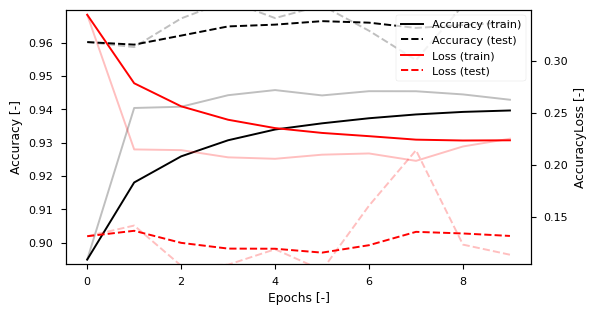

In [110]:
fig = plt.figure(figsize=(6, 3.3))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    ax_twin = ax.twinx()
    plot_training(
        ax,
        ax_twin,
        training_history_try1,
        metric="sparse_categorical_accuracy",
        metric_label="Accuracy",
        halflife=20,
    )
    # ax.set_yscale("log")
    # ax_twin.set_yscale("log")
plt.show()

In [111]:
predictions = model_1.predict(test_images)

313/313 [==============================] - 1s 2ms/step


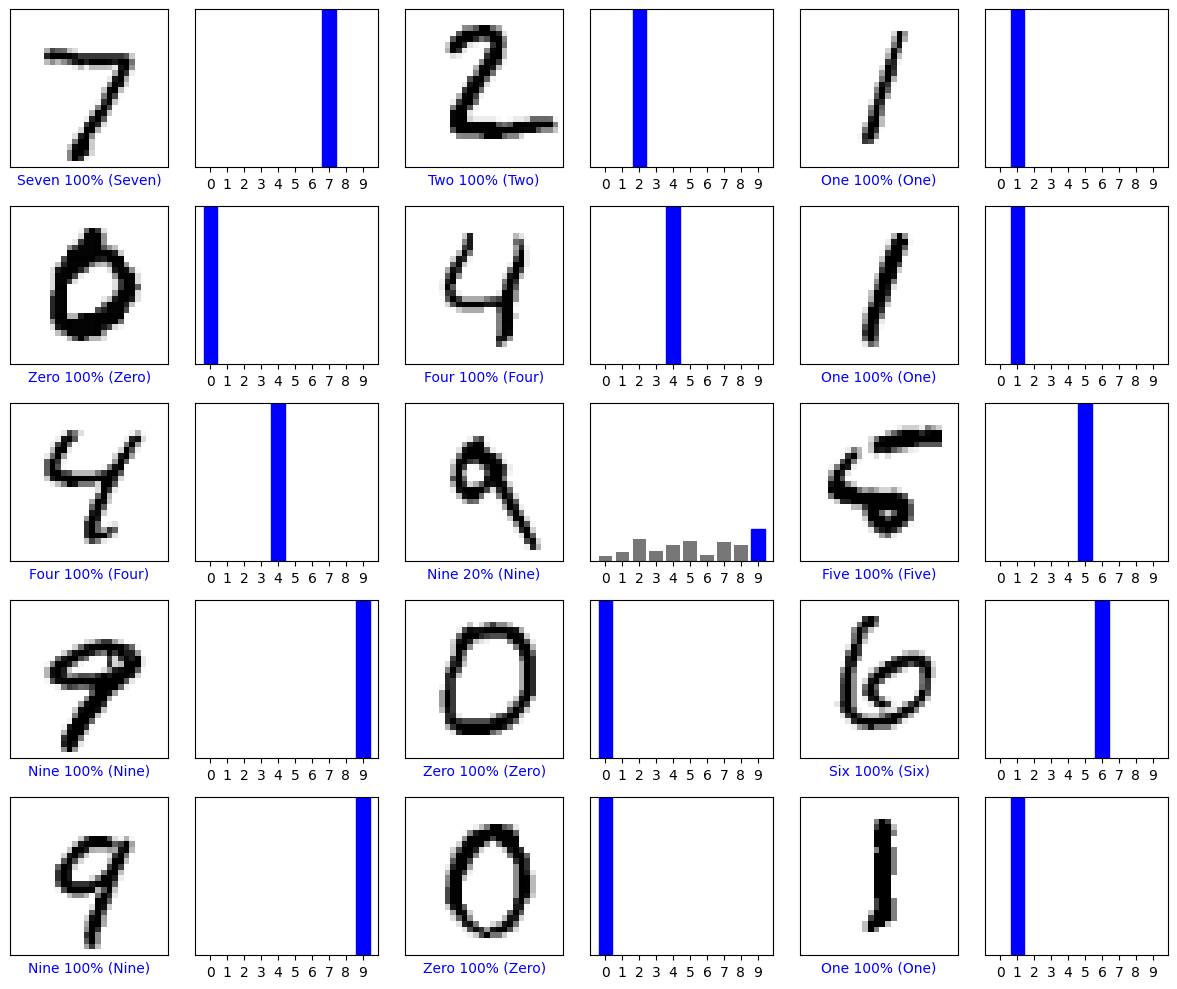

In [112]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, np.squeeze(test_images))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Exercise: Building a Face-Recognition Model Using Transfer Learning

In this exercise, we'll develop a face-recognition model capable of identifying a specific public figure. We'll employ the technique of transfer learning, leveraging a pre-trained model (VGG16) and retraining its fully connected neural network (FCNN) portion. Transfer learning is a powerful approach in deep learning, where a model developed for one task is fine-tuned to perform another related task.

Here are the steps we'll follow:

1. **Design**: Select a public figure whose face we want the model to recognize. This should be a well-known person with publicly available images.

2. **Download Initial Database**

3. **Collect Public Images from the Internet**

4. **Resize and Store**: Process the collected images to ensure uniformity. This involves resizing the images to a standard size and format, then storing them appropriately for later use.

5. **Build Dataflow from Folder and Data Augmentation**

6. **Build Model**

7. **Train**

8. **Analyze**: After training, evaluate the model's performance. This involves testing the model on a set of images it hasn't seen before and analyzing its accuracy and efficiency.

> ⚠️ **Warning:**
>
> Ensure that all images collected from the internet are public domain, or released under licenses such as CC-BY. Always respect copyright laws and usage rights when collecting and using images for training purposes.

### Download initla database

In [3]:
!wget https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/data/lab3/photos.zip

--2023-11-16 09:26:00--  https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/data/lab3/photos.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52687084 (50M) [application/zip]
Saving to: ‘photos.zip’

photos.zip          100%[===================>]  50.25M   160MB/s    in 0.3s    

2023-11-16 09:26:01 (160 MB/s) - ‘photos.zip’ saved [52687084/52687084]



In [4]:
!unzip photos.zip

Archive:  photos.zip
   creating: test/unknow/
  inflating: test/unknow/00081.png   
  inflating: test/unknow/00082.png   
  inflating: test/unknow/00083.png   
  inflating: test/unknow/00084.png   
  inflating: test/unknow/00085.png   
  inflating: test/unknow/00086.png   
  inflating: test/unknow/00087.png   
  inflating: test/unknow/00088.png   
  inflating: test/unknow/00089.png   
  inflating: test/unknow/00090.png   
   creating: train/unknow/
  inflating: train/unknow/00051.png  
  inflating: train/unknow/00052.png  
  inflating: train/unknow/00053.png  
  inflating: train/unknow/00054.png  
  inflating: train/unknow/00055.png  
  inflating: train/unknow/00056.png  
  inflating: train/unknow/00057.png  
  inflating: train/unknow/00058.png  
  inflating: train/unknow/00059.png  
  inflating: train/unknow/00060.png  
  inflating: train/unknow/00061.png  
  inflating: train/unknow/00062.png  
  inflating: train/unknow/00063.png  
  inflating: train/unknow/00064.png  
  inflating: t

### Collect photo

In [7]:
public_figure_name = 'tizzio' # <<< TO CHANGE
pathlib.Path("dirty_data").mkdir(parents=True, exist_ok=True)  # Make a folder
# Make train and test subfolders
pathlib.Path(os.path.join("test", public_figure_name)).mkdir(exist_ok=True)
pathlib.Path(os.path.join("train", public_figure_name)).mkdir(exist_ok=True)

### Resize and Store

In [27]:
TARGET_SIZE = (1024, 1024)

for i, image_name in enumerate(os.listdir("dirty_data")):
    image_path = os.path.join("dirty_data", image_name)

    # Open and resize the image
    with Image.open(image_path) as img:
        img_resized = img.resize(TARGET_SIZE)

        # Randomly choose to save in train or test folder
        if np.random.random() < 0.8:  # 80% chance to go to train, 20% to test
            save_path = os.path.join(os.path.join("train", public_figure_name), f"{i:02}.jpg")
        else:
            save_path = os.path.join(os.path.join("test", public_figure_name), f"{i:02}.json")

        # Save the resized image
        img_resized.save(save_path, "json")

### Build Dataflow from Folder and Data Augmentation

In [17]:
BATCH_SIZE = 1

train_generator = preprocessing.image.ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input)

In [28]:
testgen = train_generator.flow_from_directory("test/",
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

traingen = train_generator.flow_from_directory("train/",
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

Found 1 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


### Build model

In [ ]:
def build_model_2(input_shape, n_classes, optimizer='rmsprop'):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    for layer in conv_base.layers:
        layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = layer.Flatten(name="flatten")(top_model)
    top_model = layer.Dense(4096, activation='relu')(top_model)
    top_model = layer.Dense(1072, activation='relu')(top_model)
    top_model = layer.Dropout(0.2)(top_model)
    output_layer = layer.Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = tf.keras.models.Model(inputs=conv_base.input, outputs=output_layer)


    return model